### Evaluación de los tres modelos de regresión utilizados

- Regresión Lineal
- Máquinas de Vectores de soporte(Regresión)
- Random Forest (Regresión)

### Importacion de librerías

In [43]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib
import os


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preparación de datos
# ==============================================================================
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.api as sm

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
#from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sys
from funciones import multiple_plot, plot_roc_curve

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Cargue del dataset de pruebas y de entrenamiento

In [44]:
#Carga del dataset
dp=pd.read_csv('3_Fuel_Consumption_2000-2022_Prue.csv')
dp.shape
d = pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')
d.shape

(14093, 9)

In [45]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              1566 non-null   int64  
 1   RANGE_CATEGORY    1566 non-null   object 
 2   VEHICLE CLASS     1566 non-null   object 
 3   ENGINE SIZE       1566 non-null   float64
 4   CYLINDERS         1566 non-null   int64  
 5   FUEL              1566 non-null   object 
 6   FUEL CONSUMPTION  1566 non-null   float64
 7   KMXGALON          1566 non-null   float64
 8   EMISSIONS         1566 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 110.2+ KB


### Variables de entrada

In [46]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head(2)

RANGE_CATEGORY     VEHICLE CLASS FUEL
0     HIGH_RANGE  MIDSIZE_FULLSIZE    Z
1     HIGH_RANGE  MIDSIZE_FULLSIZE    Z

In [47]:
#Lista de variables numéricas

numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

dp[numCols].head(2)

YEAR  ENGINE SIZE  CYLINDERS  FUEL CONSUMPTION  KMXGALON  EMISSIONS
0  2000       2.7000          6           13.6000   40.2335        264
1  2000       2.7000          6           13.6000   38.6242        267

### Eliminación variable de salida

In [48]:
numCols.remove('EMISSIONS')

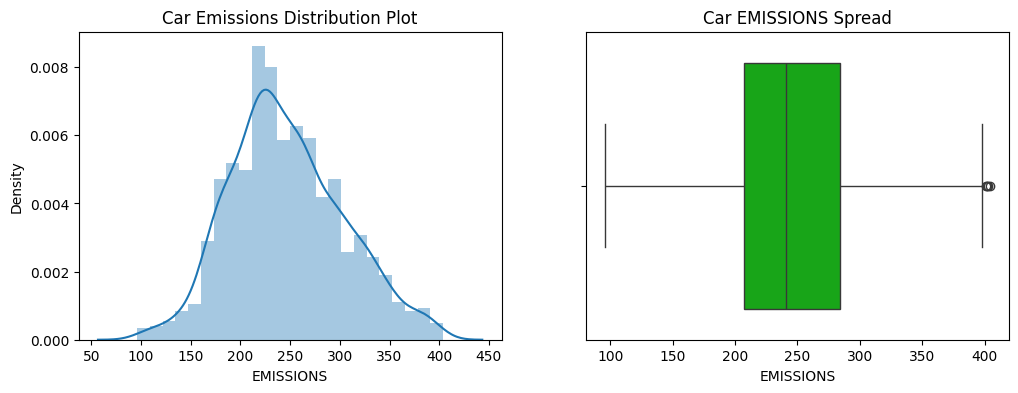

In [49]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Emissions Distribution Plot')
sns.distplot(dp.EMISSIONS)

plt.subplot(1,2,2)
plt.title('Car EMISSIONS Spread')
sns.boxplot(x=dp.EMISSIONS, palette='nipy_spectral')

plt.show()

In [50]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(dp.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   1566
mean     247
std       57
min       96
25%      207
50%      241
75%      284
85%      312
90%      326
95%      350
97.5%    371
100%     404
max      404
Name: EMISSIONS, dtype: float64


### Transformación de datos

In [51]:
#Tranformacion y = y^(1/3) Raiz cúbica
dp['EMISSIONS'] = np.cbrt(dp['EMISSIONS'])

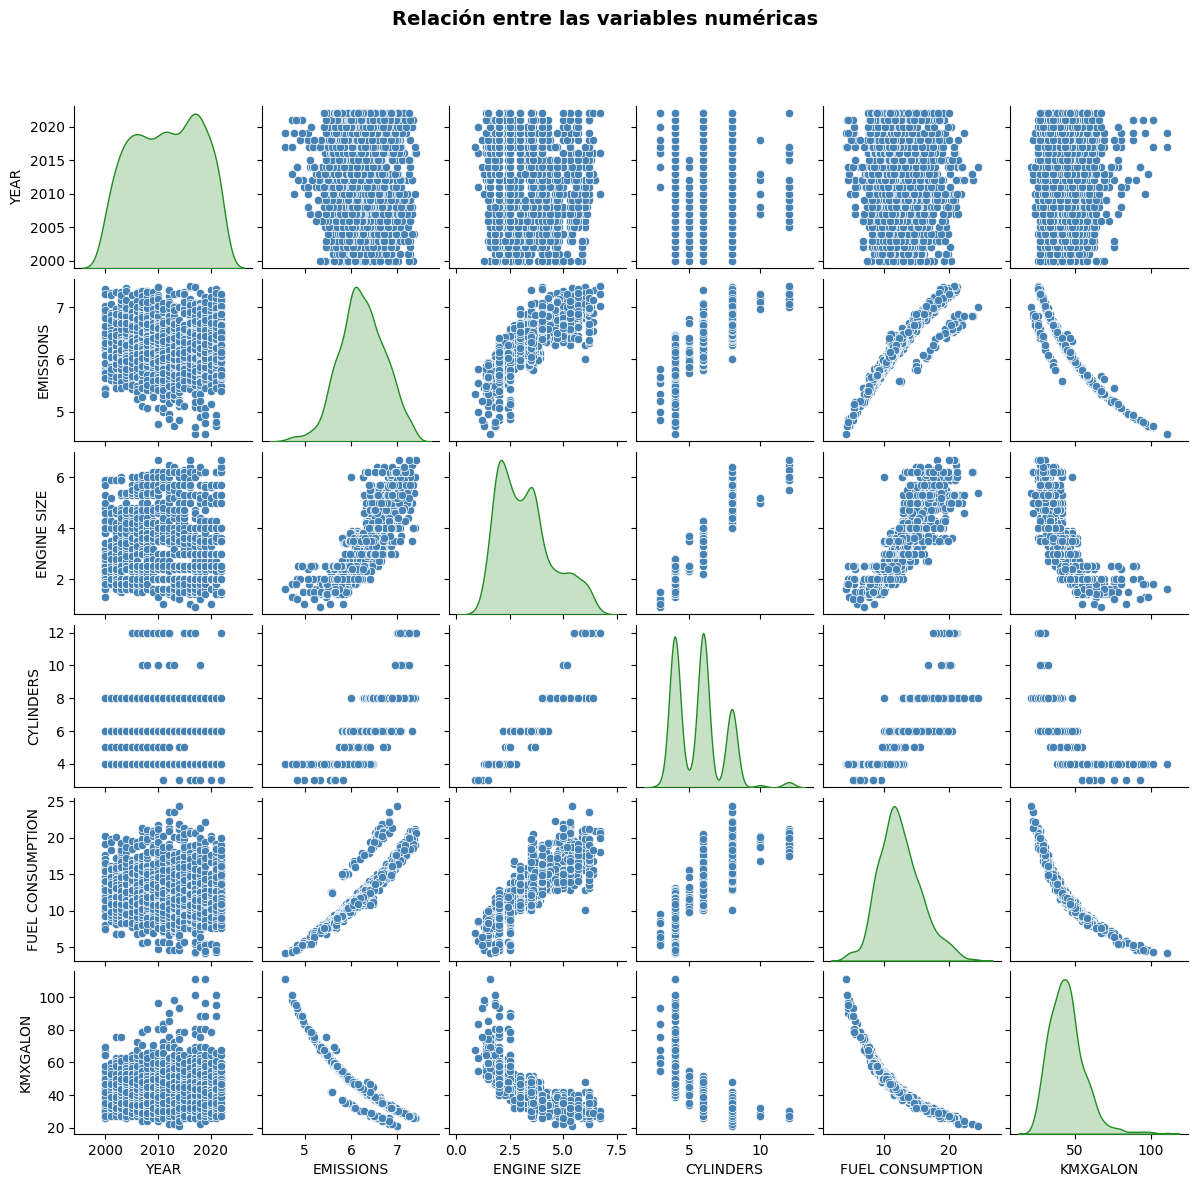

In [52]:
varTrans = ['YEAR','EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']

multiple_plot(1, dp , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [53]:
#varTrans = ['EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']
dp['ENGINE SIZE'] =  np.log(dp['ENGINE SIZE'])
dp['FUEL CONSUMPTION'] = np.log(dp['FUEL CONSUMPTION'])
dp['KMXGALON'] = np.log(dp['KMXGALON'])
dp['CYLINDERS'] = np.log(dp['CYLINDERS'])
dp['YEAR'] = np.log(dp['YEAR'])

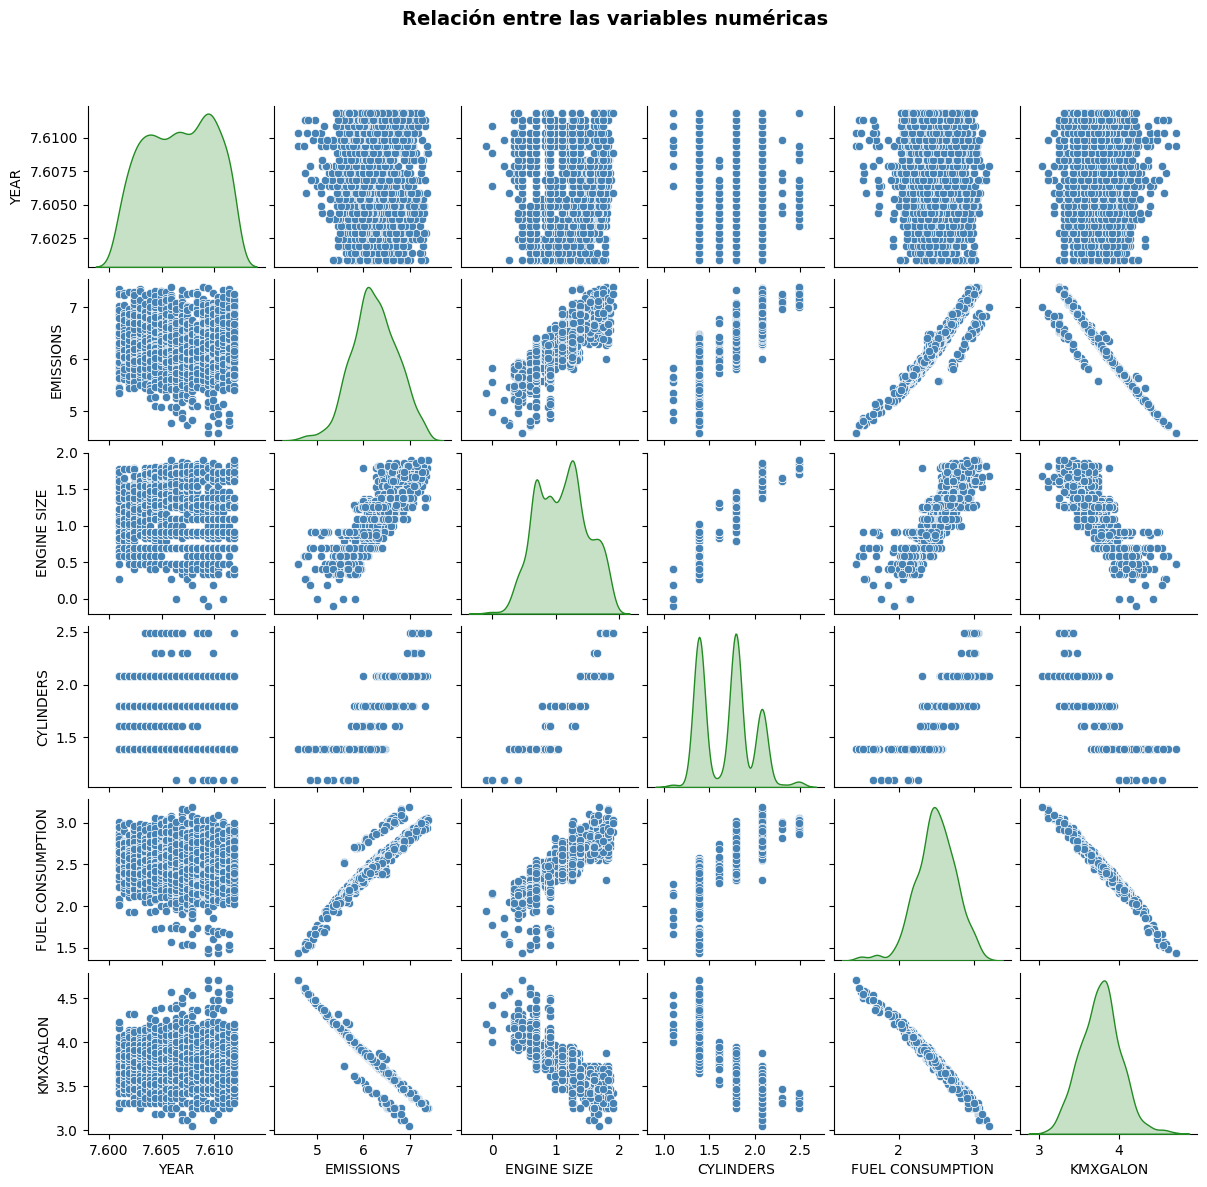

In [54]:
multiple_plot(1, dp , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [55]:

from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF
matrizCorr = dp[['EMISSIONS']+numCols].corr()
df_corr= tidy_corr_matrix(matrizCorr)

df_filtrado = df_corr.loc[df_corr['variable_2'] == 'EMISSIONS']
df_filtrado[df_filtrado['abs_r']>=0.5]
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

['KMXGALON', 'FUEL CONSUMPTION', 'ENGINE SIZE', 'CYLINDERS']


In [56]:
vDep += catCols

In [57]:
dp = dp[vDep  +['EMISSIONS']]
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   KMXGALON          1566 non-null   float64
 1   FUEL CONSUMPTION  1566 non-null   float64
 2   ENGINE SIZE       1566 non-null   float64
 3   CYLINDERS         1566 non-null   float64
 4   RANGE_CATEGORY    1566 non-null   object 
 5   VEHICLE CLASS     1566 non-null   object 
 6   FUEL              1566 non-null   object 
 7   EMISSIONS         1566 non-null   float64
dtypes: float64(5), object(3)
memory usage: 98.0+ KB


In [58]:
dp = pd.get_dummies(dp, dtype=int ,drop_first=1)

In [59]:
#Se crea una lista con todas las varibles de entrada

vDep = list(dp.columns)
vDep.remove('EMISSIONS')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = dp.drop(columns ='EMISSIONS')
y = dp['EMISSIONS']

In [60]:
num_vars = list(set(numCols) & set(vDep))


In [61]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = joblib.load('scaler/minmaxLinearRegresion.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X[num_vars] = scaler.fit_transform(X[num_vars])
X.head()

KMXGALON  FUEL CONSUMPTION  ENGINE SIZE  CYLINDERS  \
0    0.3918            0.6678       0.5473     0.5000   
1    0.3673            0.6678       0.5473     0.5000   
2    0.3673            0.6678       0.5473     0.5000   
3    0.4379            0.6107       0.5089     0.5000   
4    0.2581            0.8176       0.8441     0.7075   

   RANGE_CATEGORY_LOW_RANGE  RANGE_CATEGORY_MID_RANGE  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   VEHICLE CLASS_SEDAN_COMPACT  VEHICLE CLASS_SUV_CROSSOVER  \
0                            0                            0   
1                            0                            0   
2                            1                            0   
3                            1                            0   
4                            1                            0   

   VEHICLE CLASS_TRUCK_VAN  VEHICLE CLASS_WAGON_SPECIALTY  FUEL_X  FUEL_Z  
0                        0                              0       0       1  
1                        0                              0       0       1  
2                        0                              0       0       1  
3                        0                              0       0       1  
4                        0                              0       0       1

In [62]:
X = X.drop(["ENGINE SIZE"], axis = 1)
X = X.drop(["VEHICLE CLASS_WAGON_SPECIALTY"], axis = 1)
X = X.drop(["VEHICLE CLASS_SEDAN_COMPACT"], axis = 1)
X = X.drop(["KMXGALON"], axis = 1)

In [63]:
modelLRegresion = joblib.load('modelos/LinealRegression.pkl')

In [64]:
X = sm.add_constant(X)

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y = y.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelLRegresion.predict(X)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento
residuos_train   = prediccion_train - y

AttributeError: 'Series' object has no attribute 'flatten'

In [ ]:
#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

predicciones = modelLRegresion.predict(X)

# Concatenar X y y
df_prep = pd.DataFrame(np.c_[X, y], columns= X.columns.tolist()+['EMISSIONS'])
df_prep

const  FUEL CONSUMPTION  CYLINDERS  RANGE_CATEGORY_LOW_RANGE  \
0    1.0000            0.6678     0.5000                    0.0000   
1    1.0000            0.6678     0.5000                    0.0000   
2    1.0000            0.6678     0.5000                    0.0000   
3    1.0000            0.6107     0.5000                    0.0000   
4    1.0000            0.8176     0.7075                    0.0000   
...     ...               ...        ...                       ...   
1561 1.0000            0.4204     0.2075                    0.0000   
1562 1.0000            0.5871     0.2075                    0.0000   
1563 1.0000            0.4332     0.2075                    0.0000   
1564 1.0000            0.5625     0.2075                    0.0000   
1565 1.0000            0.5472     0.2075                    0.0000   

      RANGE_CATEGORY_MID_RANGE  VEHICLE CLASS_SUV_CROSSOVER  \
0                       0.0000                       0.0000   
1                       0.0000                       0.0000   
2                       0.0000                       0.0000   
3                       0.0000                       0.0000   
4                       0.0000                       0.0000   
...                        ...                          ...   
1561                    1.0000                       1.0000   
1562                    1.0000                       0.0000   
1563                    1.0000                       0.0000   
1564                    1.0000                       0.0000   
1565                    1.0000                       1.0000   

      VEHICLE CLASS_TRUCK_VAN  FUEL_X  FUEL_Z  EMISSIONS  
0                      0.0000  0.0000  1.0000     6.4151  
1                      0.0000  0.0000  1.0000     6.4393  
2                      0.0000  0.0000  1.0000     6.4393  
3                      0.0000  0.0000  1.0000     6.1885  
4                      0.0000  0.0000  1.0000     6.9174  
...                       ...     ...     ...        ...  
1561                   0.0000  1.0000  0.0000     5.6877  
1562                   0.0000  0.0000  1.0000     6.1885  
1563                   0.0000  1.0000  0.0000     5.6980  
1564                   0.0000  0.0000  1.0000     6.0732  
1565                   0.0000  0.0000  1.0000     6.1446  

[1566 rows x 10 columns]

In [ ]:
# Predecir los valores para df_prep utilizando el modelLRegresion y Elevar al cubo usando np.power()
resultadoPredict =np.power(modelLRegresion.predict(df_prep.drop(columns ='EMISSIONS')), 3)
resultadoPredict

0      279.9642
1      279.9642
2      279.9642
3      258.5948
4      350.1279
         ...   
1561   193.2812
1562   237.9814
1563   187.0497
1564   229.5986
1565   235.8725
Length: 1566, dtype: float64

In [ ]:
# Convertir el array numpy resultadoPredic en un DataFrame de pandas
resultadoPredict_df = pd.DataFrame(resultadoPredict, columns=['EMISSIONS_Predicted'])
resultadoPredict_df

EMISSIONS_Predicted
0                279.9642
1                279.9642
2                279.9642
3                258.5948
4                350.1279
...                   ...
1561             193.2812
1562             237.9814
1563             187.0497
1564             229.5986
1565             235.8725

[1566 rows x 1 columns]

In [ ]:
# Concatenar x_i con el DataFrame de las predicciones
concatenated_df = pd.concat([df_prep.reset_index(drop=True), resultadoPredict_df], axis=1)

# El valor de Y real se eleva al cubo
concatenated_df['EMISSIONS'] = np.power(concatenated_df['EMISSIONS'],3)

In [ ]:
# Se calcula el valor absoluto de la diferencia entre el Y real y el Y calculado
concatenated_df['dif'] = (concatenated_df['EMISSIONS'] - concatenated_df['EMISSIONS_Predicted']).abs()

In [ ]:
# Las diferencias ordenadas
concatenated_df[['EMISSIONS', 'EMISSIONS_Predicted', 'dif']].sort_values(by='dif', ascending=True)

EMISSIONS  EMISSIONS_Predicted     dif
1246   236.0000             235.9898  0.0102
1382   318.0000             317.9810  0.0190
1440   318.0000             317.9810  0.0190
1119   207.0000             206.9592  0.0408
25     207.0000             206.9592  0.0408
...         ...                  ...     ...
1533   263.0000             195.0571 67.9429
1136   255.0000             186.8992 68.1008
1262   268.0000             196.9234 71.0766
1514   272.0000             196.9234 75.0766
1510   272.0000             196.6429 75.3571

[1566 rows x 3 columns]